In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-oeh5o8l8
  Running command git clone --filter=blob:none -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-oeh5o8l8
  Resolved https://github.com/desi-bgs/bgs-cmxsv.git to commit a5f7c97e3d4b9190e9ca7d174561b8a9a7aa877a
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1

# Get all SV1 exposures through September 28, 2021

In [3]:
# read in Aaron's GFA data of exposures through 2021/02/01
gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210928.fits')['MJD', 'NIGHT', 'EXPID', 'AIRMASS', 'SKY_MAG_AB', 'MOON_ILLUMINATION', 'MOON_SEP_DEG', 'MOON_ZD_DEG', 'TRANSPARENCY']
exps = gfa.group_by(['EXPID']).groups.aggregate(np.median)

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/astropy/table/groups.py:258: UserWarning: Warning: converting a masked element to nan.
  vals = np.array([func(par_col[i0: i1]) for i0, i1 in zip(i0s, i1s)])


In [4]:
exps[:5]

MJD,NIGHT,EXPID,AIRMASS,SKY_MAG_AB,MOON_ILLUMINATION,MOON_SEP_DEG,MOON_ZD_DEG,TRANSPARENCY
float64,float64,int64,float64,float64,float64,float64,float64,float64
59198.08855637566,20201214.0,67678,1.0245214875180846,20.306343899519227,0.00241368938034363,117.73375330282161,107.18208872228597,0.9421358004271907
59198.09340272179,20201214.0,67679,1.0191465895617893,20.253945455193083,0.0024700775622045036,117.6702245451234,108.53487794245974,0.9031746394430591
59198.09831583536,20201214.0,67680,1.01446950715555,20.033265558674195,0.002528564919546986,117.60668865736183,109.91266545656522,0.9527972869199486
59198.10320283822,20201214.0,67681,1.0105723623262,20.218061565792368,0.002586841487755262,117.5431524606984,111.28808981011574,0.9507191598338869
59198.10810292036,20201214.0,67682,1.0074075191686402,20.202504822354022,0.0026464129287131835,117.47957321208305,112.6723796158372,0.9562083786822335


In [5]:
print('%i exposures' % len(exps))

4226 exposures


# compile all sky spectra

In [6]:
# get sky surface brightnesses
Iskies = []
for i in np.arange(len(exps)):
    wave, Isky = sv1.get_obs_sky(int(exps[i]['NIGHT']), int(exps[i]['EXPID']), 'model', redux="daily");
    Iskies.append(Isky * 1e17)

20201220-00069029-b: no spectra for model
20201220-00069029-r: no spectra for model
20201220-00069029-z: no spectra for model
20201220-00069032-b: no spectra for model
20201220-00069032-r: no spectra for model
20201220-00069032-z: no spectra for model
20201220-00069056-b: no spectra for model
20201220-00069056-r: no spectra for model
20201220-00069056-z: no spectra for model
20201220-00069057-b: no spectra for model
20201220-00069057-r: no spectra for model
20201220-00069057-z: no spectra for model
20201220-00069058-b: no spectra for model
20201220-00069058-r: no spectra for model
20201220-00069058-z: no spectra for model
20201220-00069059-b: no spectra for model
20201220-00069059-r: no spectra for model
20201220-00069059-z: no spectra for model
20201220-00069060-b: no spectra for model
20201220-00069060-r: no spectra for model
20201220-00069060-z: no spectra for model
20201220-00069061-b: no spectra for model
20201220-00069061-r: no spectra for model
20201220-00069061-z: no spectra fo

In [7]:
# only keep exposures where we have sky data
Iskies = np.array(Iskies)

has_sky = (np.sum(np.array(Iskies), axis=1) > 0.)
print('%i of %i has sky' % (np.sum(has_sky), len(has_sky)))
      
exps = exps[has_sky]
Iskies = Iskies[has_sky,:]

3836 of 4226 has sky


In [8]:
# observing conditions from median value of the GFAs
airmass = exps['AIRMASS']
moon_frac = exps['MOON_ILLUMINATION']
moon_sep = exps['MOON_SEP_DEG']
moon_alt = 90. - exps['MOON_ZD_DEG']
transp = exps['TRANSPARENCY']

[Text(0, -0.2, ''),
 Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4000000000000001, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0000000000000002, ''),
 Text(0, 1.2000000000000002, '')]

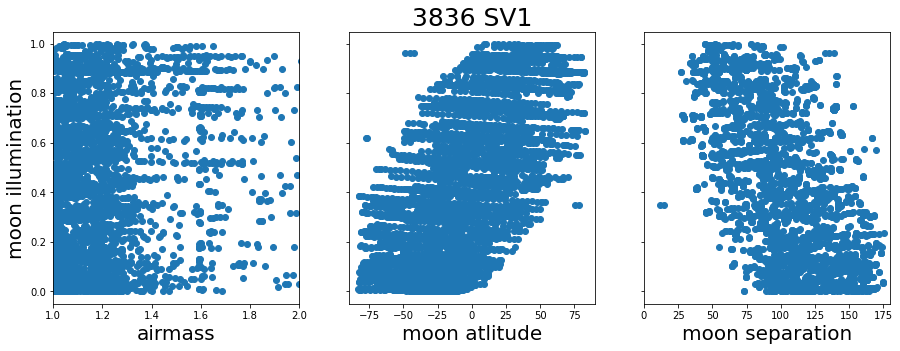

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass, moon_frac, c='C0')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt, moon_frac, c='C0')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])
sub.set_title('%i SV1' % len(exps), fontsize=25)

sub = fig.add_subplot(133)
sub.scatter(moon_sep, moon_frac, c='C0')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

In [10]:
# save observing conditions and sky fluxes to file
exps.write('/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.obs_cond.hdf5', format='hdf5', overwrite=True)
np.save('/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.Isky.npy', Iskies)
np.save('/global/cfs/cdirs/desi/users/chahah/sky_sv1/sv1.all_exps.20210928.wave.npy', wave)

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/astropy/io/misc/hdf5.py:268: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  warnings.warn("table path was not set via the path= argument; "
